# Data mining techniques: Assignment 2

This environment makes use of the R statistical analytics software tool

In [1]:
library("ggplot2")
library("grid")
library("gridExtra")
library("scales")
library("plyr")
library("corrplot")
library("gbm")

Warning message:
“package ‘ggplot2’ was built under R version 3.4.4”Warning message:
“package ‘scales’ was built under R version 3.4.4”Warning message:
“package ‘plyr’ was built under R version 3.4.4”Warning message:
“package ‘corrplot’ was built under R version 3.4.4”corrplot 0.84 loaded
Warning message:
“package ‘gbm’ was built under R version 3.4.4”Loading required package: survival
Loading required package: lattice
Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.3


# Load the data

In [2]:
trainPath <- "/home/kevin/data_mining/data/assignment2/train.csv"
testPath <- "/home/kevin/data_mining/data/assignment2/test.csv"

trainNames <- colnames(read.csv(trainPath,nrows = 1))
testNames <- colnames(read.csv(testPath,nrows = 1))

train <- read.csv(trainPath,header=F,skip=1,nrows = 200000)
#test <- read.csv(testPath,header=F,skip=1,nrows = 20)

#train <- read.csv(trainPath)
#test <- read.csv(testPath)

colnames(train) <- trainNames
#colnames(test) <- testNames

head(train)

srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,⋯,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
1,2013-04-04 08:32:15,12,187,NULL,NULL,219,893,3,3.5,⋯,NULL,NULL,NULL,NULL,0,0,NULL,0,NULL,0
1,2013-04-04 08:32:15,12,187,NULL,NULL,219,10404,4,4.0,⋯,NULL,NULL,NULL,NULL,0,0,NULL,0,NULL,0
1,2013-04-04 08:32:15,12,187,NULL,NULL,219,21315,3,4.5,⋯,NULL,NULL,NULL,NULL,0,0,NULL,0,NULL,0
1,2013-04-04 08:32:15,12,187,NULL,NULL,219,27348,2,4.0,⋯,NULL,NULL,NULL,NULL,-1,0,5,0,NULL,0
1,2013-04-04 08:32:15,12,187,NULL,NULL,219,29604,4,3.5,⋯,NULL,NULL,NULL,NULL,0,0,NULL,0,NULL,0
1,2013-04-04 08:32:15,12,187,NULL,NULL,219,30184,4,4.5,⋯,NULL,NULL,NULL,NULL,0,0,7,0,NULL,0


## Convert Factors into numeric variables

In [3]:
factor_cols <- unlist(lapply(train, is.factor))
factor_cols["date_time"] <- FALSE

#train[factor_cols] <- as.numeric(as.character(train[factor_cols]))

for (name in colnames(train[factor_cols])){
    train[name] <- as.numeric(sub('NULL',NA,as.character(train[name][,1])))
}

head(train)

srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,⋯,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
1,2013-04-04 08:32:15,12,187,NA,NA,219,893,3,3.5,⋯,NA,NA,NA,NA,0,0,NA,0,NA,0
1,2013-04-04 08:32:15,12,187,NA,NA,219,10404,4,4.0,⋯,NA,NA,NA,NA,0,0,NA,0,NA,0
1,2013-04-04 08:32:15,12,187,NA,NA,219,21315,3,4.5,⋯,NA,NA,NA,NA,0,0,NA,0,NA,0
1,2013-04-04 08:32:15,12,187,NA,NA,219,27348,2,4.0,⋯,NA,NA,NA,NA,-1,0,5,0,NA,0
1,2013-04-04 08:32:15,12,187,NA,NA,219,29604,4,3.5,⋯,NA,NA,NA,NA,0,0,NA,0,NA,0
1,2013-04-04 08:32:15,12,187,NA,NA,219,30184,4,4.5,⋯,NA,NA,NA,NA,0,0,7,0,NA,0


# Initial data exploration

## Plot missing values

In [4]:
# Get NA value booleans
nas <- is.na(train)

len.nas <- length(nas[,1])

# Initialize NA vector
na.vec <- vector(mode="integer",length=length(colnames(train)))

# Sum the NA values and fill NA vector
for (i in 1:length(na.vec)){
    na.vec[i] <- sum(nas[,i]) / len.nas
}

# Create bar plot Data Frame
na.df <- data.frame(colnames(train),na.vec)
colnames(na.df) <- c("attribute","missing_values")

# Sort by number of missing values
position <- arrange(na.df,missing_values)["attribute"][,1]

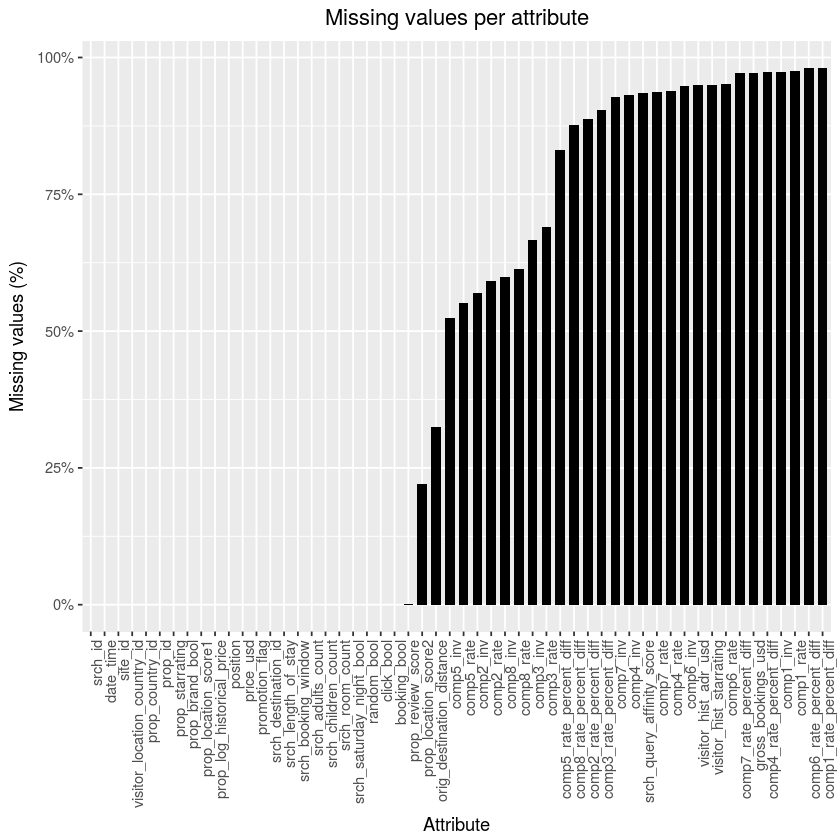

In [5]:
# Plot missing values bar plot
ggplot(data=na.df,aes(x=factor(attribute),y=missing_values)) + 
geom_bar(stat="identity",width=0.7, fill="black") +
theme(axis.text.x = element_text(angle = 90, hjust = 1), plot.title = element_text(hjust = 0.5)) + 
scale_x_discrete(limits=position) + scale_y_continuous(labels=percent) +
labs(title="Missing values per attribute", x="Attribute", y="Missing values (%)")

## Data summaries

In [6]:
summary(train)

    srch_id                     date_time          site_id      
 Min.   :     1   2012-11-02 14:04:51:     95   Min.   : 1.000  
 1st Qu.: 82936   2012-12-26 10:59:30:     87   1st Qu.: 5.000  
 Median :166507   2013-05-15 18:39:51:     70   Median : 5.000  
 Mean   :166367   2012-11-23 07:28:55:     69   Mean   : 9.953  
 3rd Qu.:249724   2012-12-03 10:33:44:     68   3rd Qu.:14.000  
 Max.   :332785   2012-12-26 14:26:28:     68   Max.   :34.000  
                  (Other)            :4957890                   
 visitor_location_country_id visitor_hist_starrating visitor_hist_adr_usd
 Min.   :  1.0               Min.   :1               Min.   :   0        
 1st Qu.:100.0               1st Qu.:3               1st Qu.: 110        
 Median :219.0               Median :3               Median : 152        
 Mean   :175.3               Mean   :3               Mean   : 176        
 3rd Qu.:219.0               3rd Qu.:4               3rd Qu.: 213        
 Max.   :231.0               Max.   

In [7]:
#summary(test)

# Exploratory data analysis: Investigate Missing Values

## Competitor attributes

In [48]:
comp_data <- function(df,attr_name){
    
    booked <- df[,"booking_bool"] == 1
    clicked <- df[,"click_bool"] == 1

    books <- data.frame()
    clicks <- data.frame()

    for (i in c(1:8)){
        str <- sprintf("comp%i_%s",i,attr_name)
        
        # Full value counts
        full <- as.data.frame(table(df[,str], useNA="always"))
    
        full[,"Competitor"] <- factor(i,levels=c(1:8))
    
        full[,"Var1"] <- factor(full[,"Var1"],levels=c(-1,0,1,"NA"))
        full[is.na(full[,"Var1"]),"Var1"] <- factor("NA",levels=c(-1,0,1,"NA"))
    
        # Booked value counts
        book <- as.data.frame(table(df[booked,str], useNA="always"))
    
        book[,"Competitor"] <- factor(i,levels=c(1:8))
    
        book[,"Var1"] <- factor(book[,"Var1"],levels=c(-1,0,1,"NA"))
        book[is.na(book[,"Var1"]),"Var1"] <- factor("NA",levels=c(-1,0,1,"NA"))
    
        book[,"Freq"] <- book[,"Freq"] / full[,"Freq"]
    
        # Click value counts
        click <- as.data.frame(table(df[clicked,str], useNA="always"))
        
        click[,"Competitor"] <- factor(i,levels=c(1:8))
    
        click[,"Var1"] <- factor(click[,"Var1"],levels=c(-1,0,1,"NA"))
        click[is.na(click[,"Var1"]),"Var1"] <- factor("NA",levels=c(-1,0,1,"NA"))
    
        click[,"Freq"] <- click[,"Freq"] / full[,"Freq"]
    
        books <- rbind(books,book)
        clicks <- rbind(clicks,click)
    }
    
    return(list(books,clicks))
}

### Competitor rates

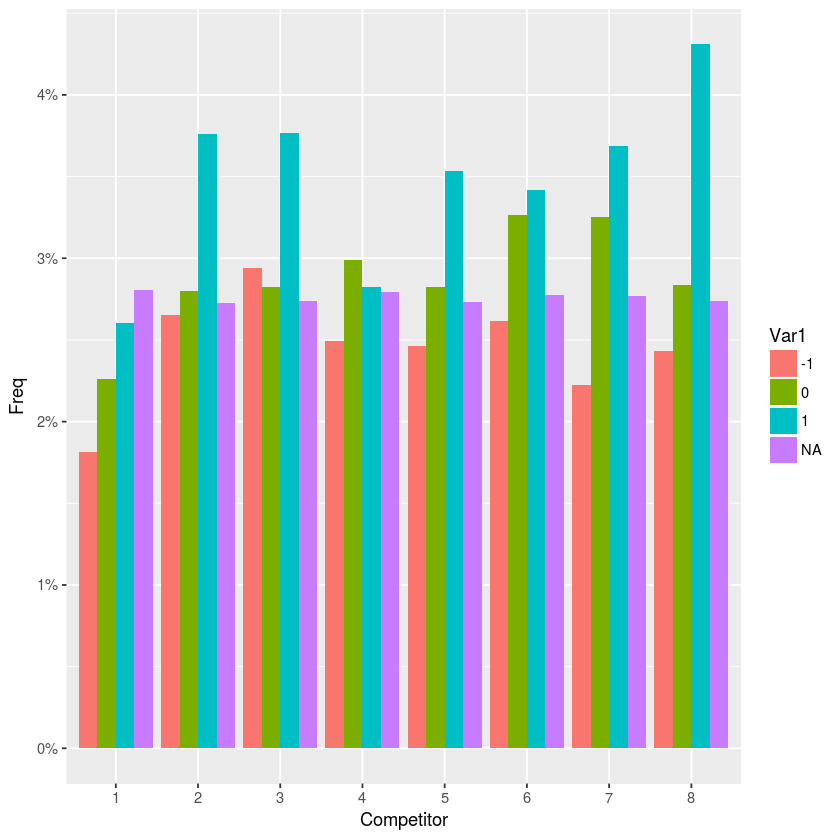

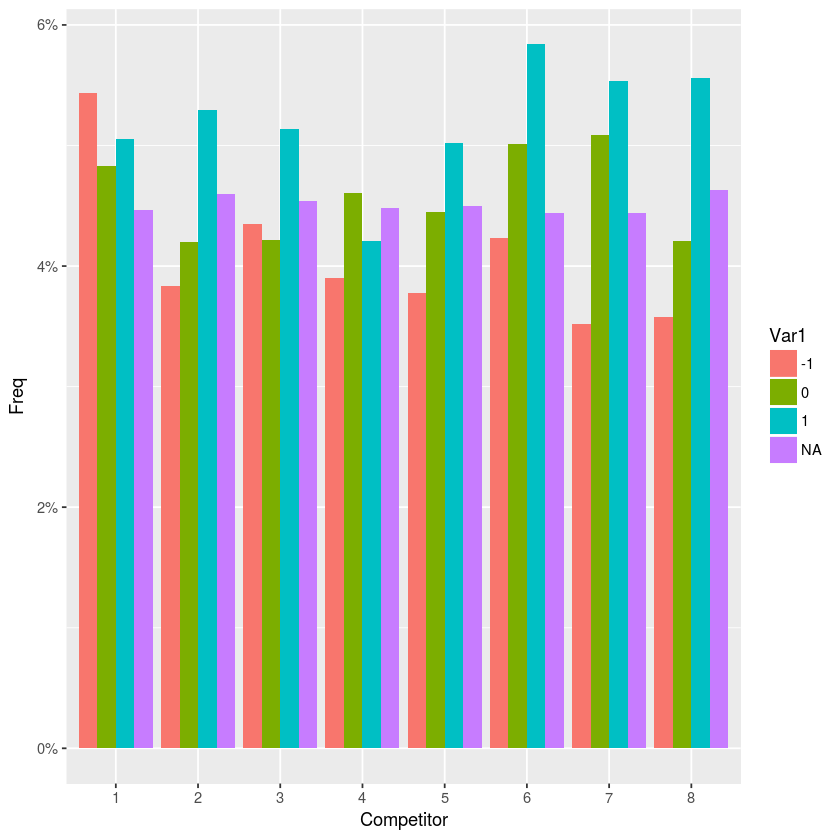

In [57]:
data <- comp_data(train,"rate")

books <- data[[1]]
clicks <- data[[2]]

ggplot(data=books, aes(x=Competitor,y=Freq,fill=Var1)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent)

ggplot(data=clicks, aes(x=Competitor,y=Freq,fill=Var1)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent)

### Competitor inv

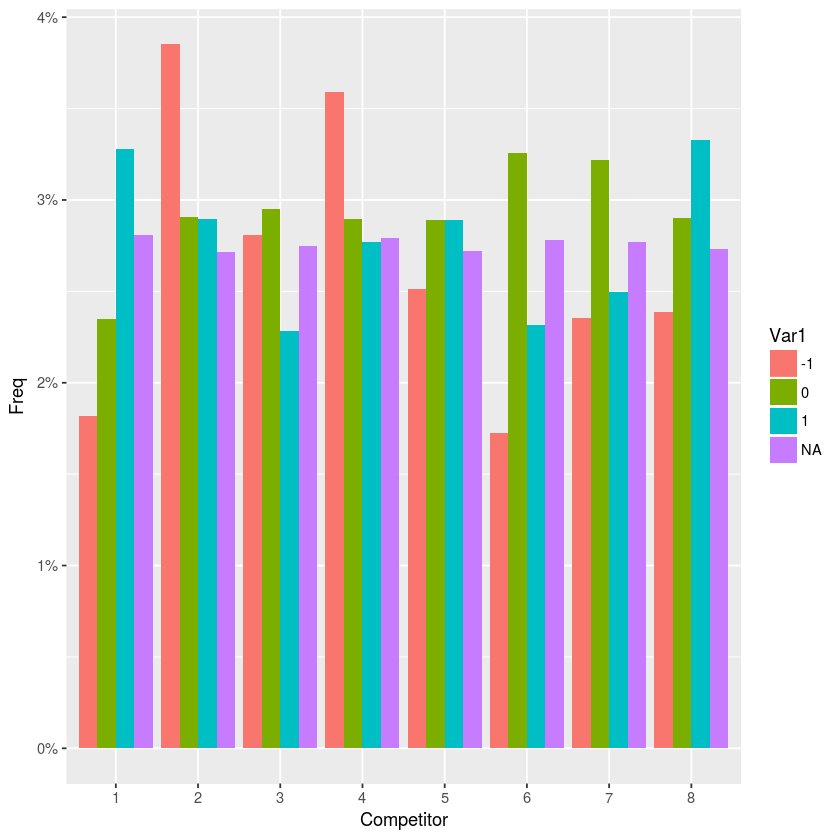

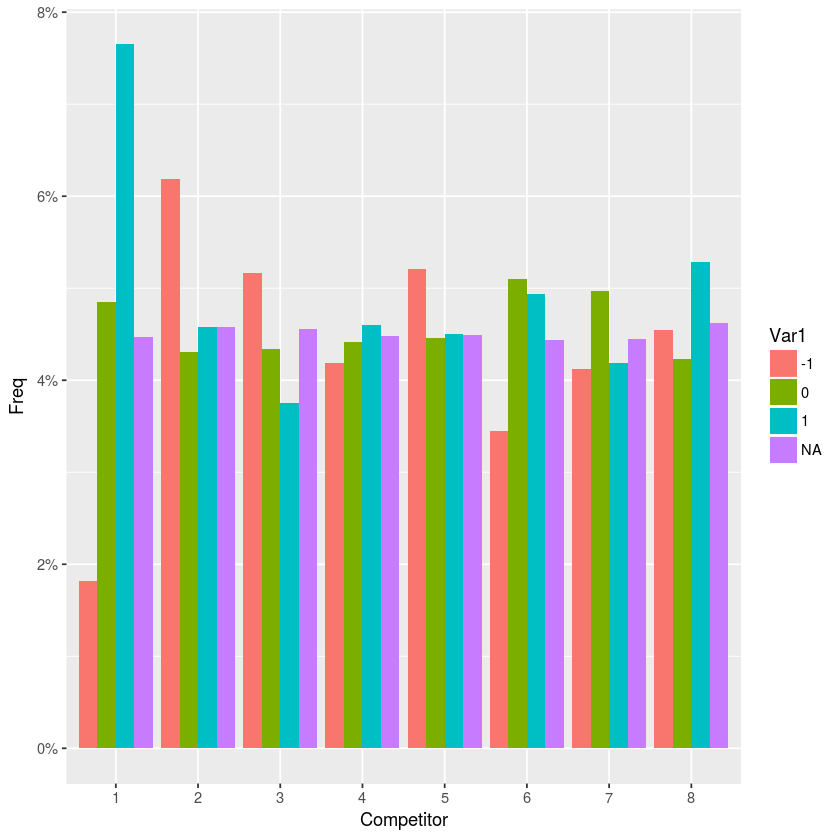

In [58]:
data <- comp_data(train,"inv")

books <- data[[1]]
clicks <- data[[2]]

ggplot(data=books, aes(x=Competitor,y=Freq,fill=Var1)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent)

ggplot(data=clicks, aes(x=Competitor,y=Freq,fill=Var1)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent)

## Origin-destination distance

## Property Starrating

## Location score 2

# Fill in missing values

In [8]:
train["prop_review_score"][is.na(train["prop_review_score"])] <- 0

## Fill origin-destination distance

In [16]:
if (FALSE){

visitor_country_id <- train["visitor_location_country_id"][,]
prop_country_id <- train["prop_country_id"][,]

sum.distances <- matrix(0,nrow=max(as.numeric(prop_country_id)),ncol=max(as.numeric(visitor_country_id)))
count.distances <- matrix(0,nrow=max(as.numeric(prop_country_id)),ncol=max(as.numeric(visitor_country_id)))

sprintf("NAs before: %i",sum(is.na(train[,"orig_destination_distance"])))

for (i in 1:nrow(train)){
    vis_id <- train[i,"visitor_location_country_id"]
    prop_id <- train[i,"prop_country_id"]
    distance <- train[i,"orig_destination_distance"]
    
    if (!is.na(distance)){
        sum.distances[prop_id,vis_id] <- sum.distances[prop_id,vis_id] + distance
        count.distances[prop_id,vis_id] <- count.distances[prop_id,vis_id] + 1
    }
}

mean.distances <- sum.distances / count.distances

for (i in 1:nrow(train)){
    vis_id <- train[i,"visitor_location_country_id"]
    prop_id <- train[i,"prop_country_id"]
    distance <- train[i,"orig_destination_distance"]
    
    if (is.na(distance)){
        train[i,"orig_destination_distance"] <- mean.distances[prop_id,vis_id]
    }
}

sprintf("NAs after: %i",sum(is.na(train[,"orig_destination_distance"])))

}

# Exploratory data analysis: Feature Relations

# Feature extraction and Engineering

## Extract time features from date_time

In [10]:
date.strings <- train["date_time"][,]

date <- strptime(date.strings,format="%Y-%m-%d %H:%M:%OS")

date.df <- data.frame(year=as.numeric(format(date,format="%Y")),month=as.numeric(format(date,format="%m")),
                      day=as.numeric(format(date,format="%d")),hour=as.numeric(format(date,format="%H")),
                      minute=as.numeric(format(date,format="%M")),second=as.numeric(format(date,format="%OS")))

colnames(date.df) = paste("date_",colnames(date.df),sep="")

head(date.df)

date_year,date_month,date_day,date_hour,date_minute,date_second
2013,4,4,8,32,15
2013,4,4,8,32,15
2013,4,4,8,32,15
2013,4,4,8,32,15
2013,4,4,8,32,15
2013,4,4,8,32,15


In [11]:
# Replace date_time with relevant time values

train <- subset(train,select=-date_time)

for (col in c("date_year","date_month","date_hour")){
    train[,col] <- date.df[col]
}

num.attr <- length(colnames(train))

train <- train[,colnames(train)[c(1,(num.attr-2):num.attr,2:(num.attr-3))]]

# Exploratory data analysis: Feature Importance

## Plot something

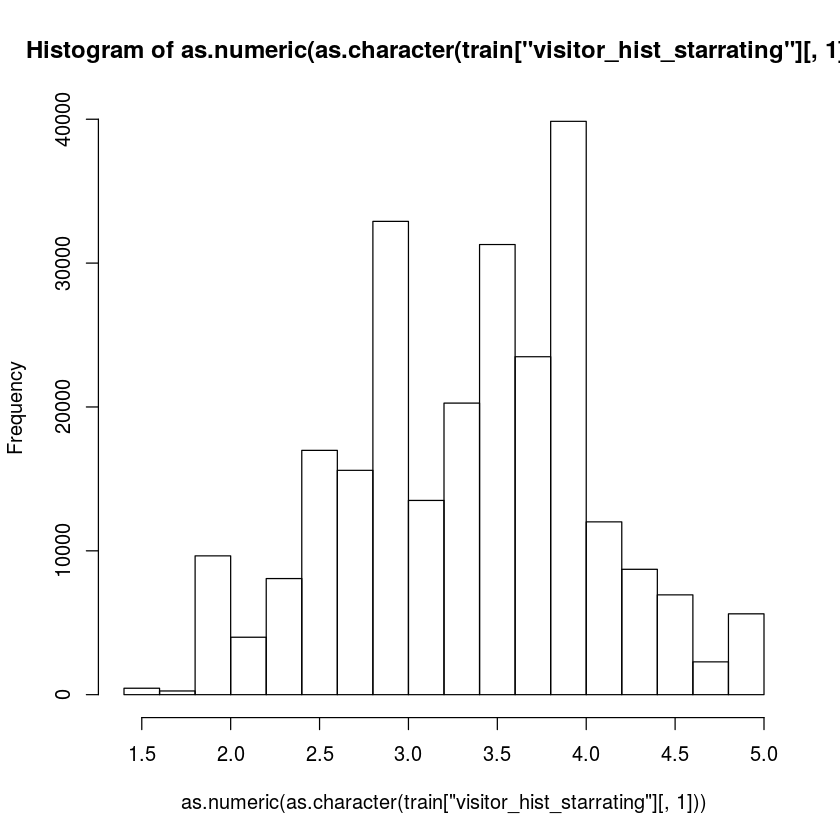

In [12]:
#ggplot(data=train,aes(x=visitor_hist_starrating)) + geom_histogram(bins=30)
hist(as.numeric(as.character(train["visitor_hist_starrating"][,1])))

# Correlation plot of the numeric attributes

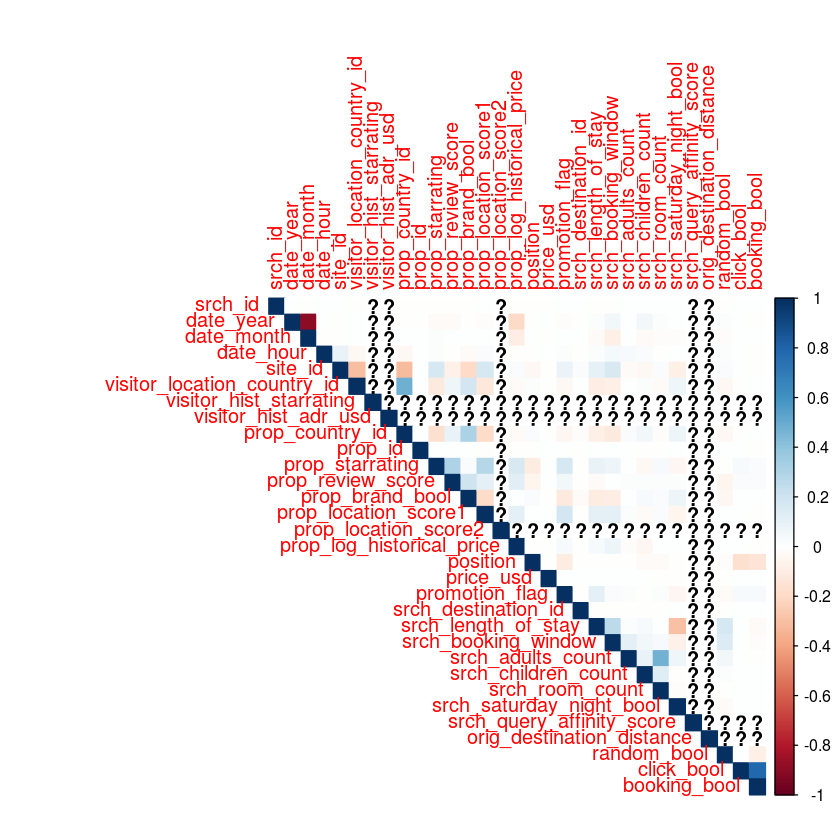

In [13]:
train.nums <- unlist(lapply(train, is.numeric))
l.idx <- length(colnames(train))

corrplot(cor(train[colnames(train)[c(1:29,l.idx-2,l.idx)]]),method="color",type="upper")

# Modeling and Evaluation

## Split the data for modeling

In [12]:
# Determine approximate values for the test and validation sets
ntest <- as.integer(0.15 * nrow(train))
nvalid <- as.integer(0.15 * nrow(train))

# Initial test set split index
test.idx <- nrow(train) - ntest

# First search id for the test set
split.id <- train[test.idx,"srch_id"]

# Determine first incidence of search_id
for (i in test.idx:2){
    if (train[i-1,"srch_id"] != split.id){
        test.idx <- i
        break
    }
}

# Get test set from train
train.test <- train[test.idx:nrow(train),]

head(train.test)

[1] 170000

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,⋯,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
169977,11370,2013-01-21 12:19:16,5,219,NA,NA,219,2506,3,4.0,⋯,NA,NA,NA,NA,NA,NA,NA,0,NA,0
169978,11370,2013-01-21 12:19:16,5,219,NA,NA,219,9223,2,2.5,⋯,NA,NA,NA,NA,NA,NA,NA,0,NA,0
169979,11370,2013-01-21 12:19:16,5,219,NA,NA,219,9456,4,4.0,⋯,NA,NA,NA,NA,NA,NA,NA,0,NA,0
169980,11370,2013-01-21 12:19:16,5,219,NA,NA,219,12950,2,4.0,⋯,NA,NA,NA,NA,NA,NA,NA,0,NA,0
169981,11370,2013-01-21 12:19:16,5,219,NA,NA,219,19626,5,4.5,⋯,NA,NA,NA,NA,NA,NA,NA,0,NA,0
169982,11370,2013-01-21 12:19:16,5,219,NA,NA,219,21244,4,4.5,⋯,NA,NA,NA,NA,NA,NA,NA,1,530.6,1
